In [1]:
from evautils import sequtils
import numpy as np
from collections import OrderedDict
import h5py
import gzip

In [2]:
def load_sequences(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        line=line.decode('utf8').split()
        seqs[line[0]] = line[1]
    fp.close()
    print("#Loaded " + str(len(seqs)) + " sequences from " + seqfile)
    return seqs

In [3]:
MOTIF_MATCHES_FILE = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/K562/sequences/fimo_out/fimo.txt'
SEQ_FILE = '/users/eprakash/git/interpret-benchmark/scripts/K562/sim_ig_seqs.txt.gz'
#'/users/eprakash/git/interpret-benchmark/scripts/top_10k_no_implant_neg_sim_positives.txt.gz'
IG20_20_GRADS_FILE='/users/eprakash/git/interpret-benchmark/scripts/K562/sim_ig-20-20.h5'
#'/users/eprakash/git/interpret-benchmark/scripts/no_neg_implant_imp_scores.h5'

motif_matches = sequtils.load_fimo_motif_matches(MOTIF_MATCHES_FILE, True)
seqs=load_sequences(SEQ_FILE)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/K562/sequences/fimo_out/fimo.txt ...
#Loaded 1934550 motif matches in 691211 sequences
#Loading /users/eprakash/git/interpret-benchmark/scripts/K562/sim_ig_seqs.txt.gz ...
#Loaded 3 sequences from /users/eprakash/git/interpret-benchmark/scripts/K562/sim_ig_seqs.txt.gz


In [4]:
for key in list(motif_matches.keys()):
    if key not in list(seqs.keys()):
        del motif_matches[key]
print(len(motif_matches))

3


In [5]:
def get_grads(grads_file):
    h5f = h5py.File(grads_file,'r')
    print(h5f.keys())
    grads = np.array(h5f.get("interpolated_gradients"))
    h5f.close()
    return np.array(grads)

In [6]:
ig20_shuff20_grads=get_grads(IG20_20_GRADS_FILE)
print(ig20_shuff20_grads.shape)

<KeysViewHDF5 ['interpolated_gradients']>
(60, 20, 400, 4)


In [7]:
seqids = list(seqs.keys())
relevant_indices_list, relevant_labels_list=sequtils.get_relevant_labels_in_order_of_scores(seqids, motif_matches)
print(relevant_labels_list)

Motif matches sequences are 3
Supplied labels are 3
3
3
['chr9:136245629-136246029', 'chr9:137551664-137552064', 'chr21:43426948-43427348']


In [8]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seqs[label]) for label in relevant_labels_list])
print(onehot_data.shape)

(3, 400, 4)


In [9]:
def get_mean_ref_grads(grads, num_seqs, num_refs):
    mean_ref_grads = np.zeros((num_seqs,num_refs,400,4))
    r=0
    for i in range(0, len(grads), num_refs):
        mean_ref_grads[r] = np.sum(grads[i:i+num_refs], axis=0)/num_refs
        r=r+1
    return mean_ref_grads

In [10]:
mean_ref_ig20_shuff20_grads = get_mean_ref_grads(ig20_shuff20_grads, len(onehot_data), 20)
mean_ref_ig20_shuff20_grads = np.sum(mean_ref_ig20_shuff20_grads, axis=3)
print(mean_ref_ig20_shuff20_grads.shape)

(3, 20, 400)


chr9:136245629-136246029



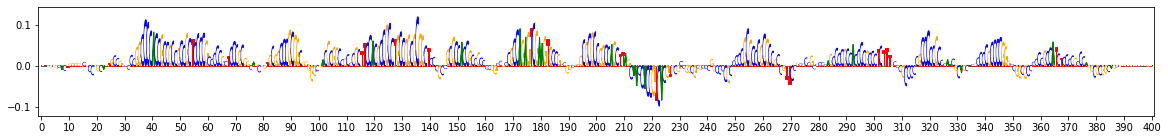

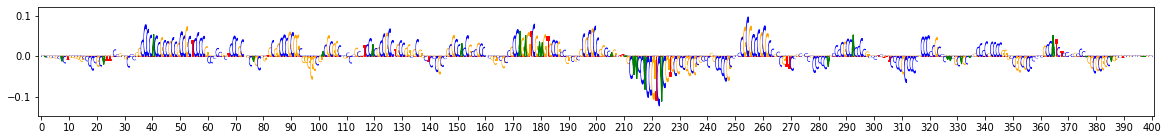

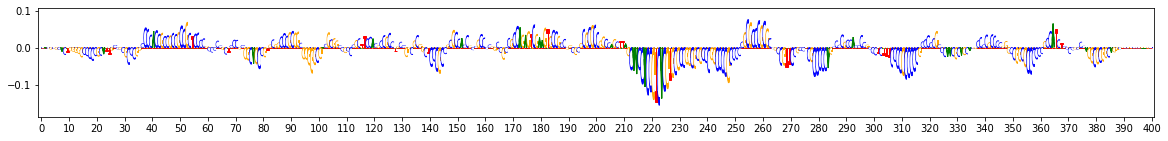

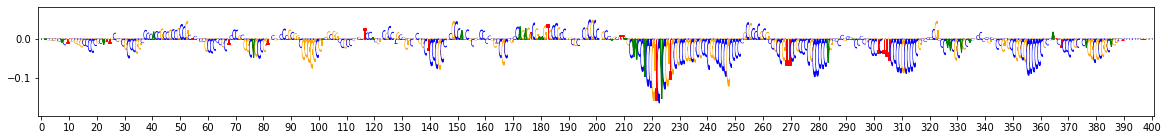

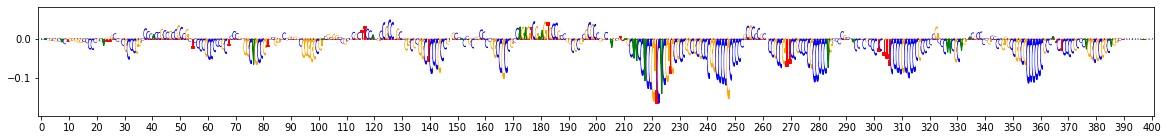

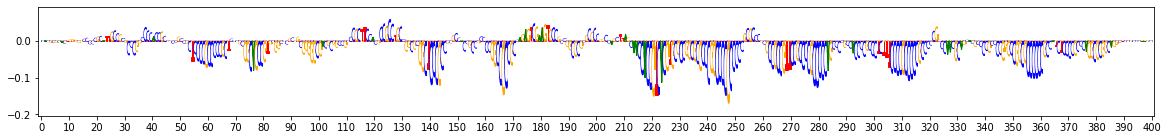

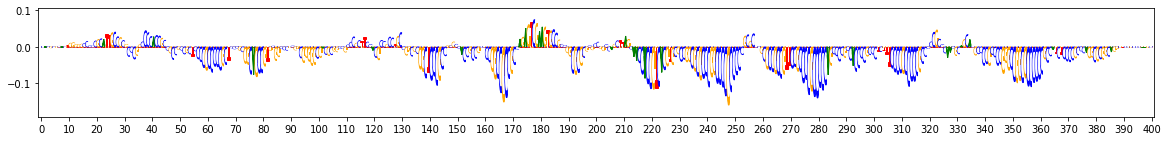

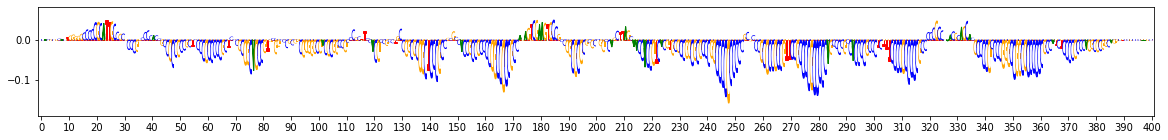

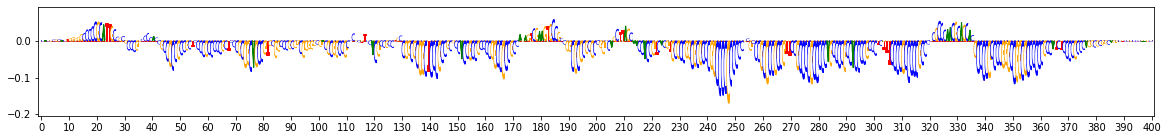

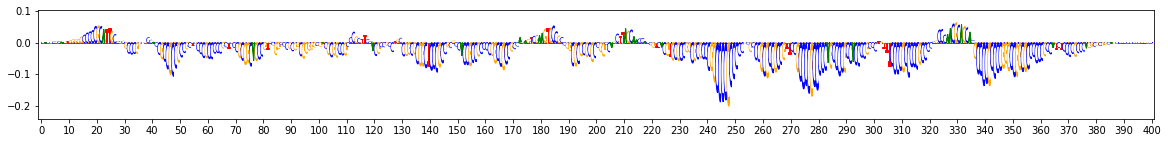

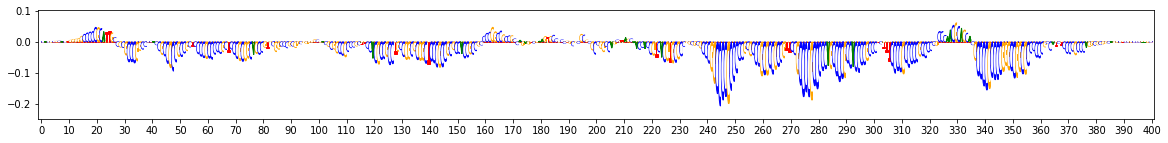

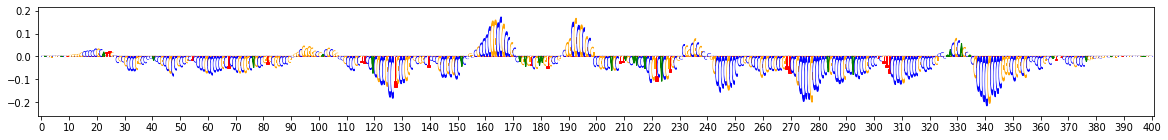

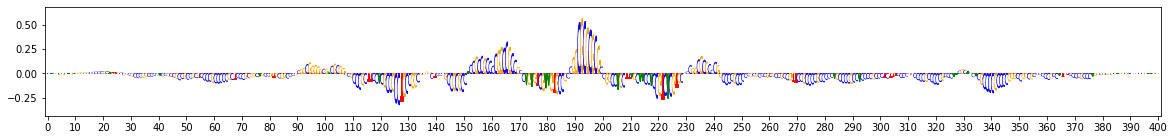

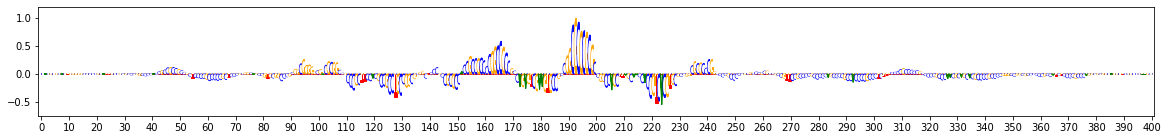

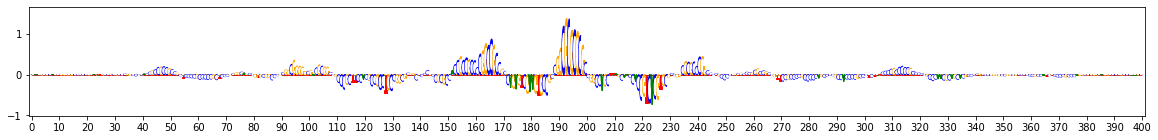

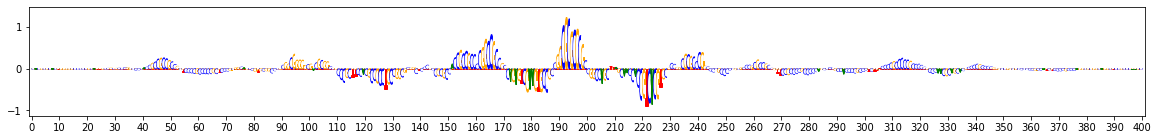

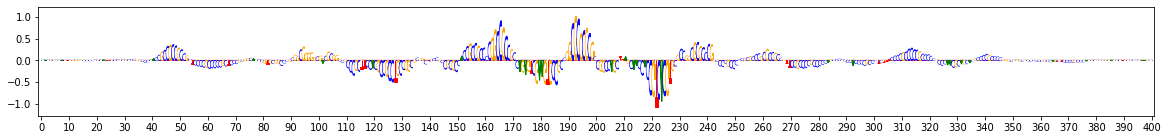

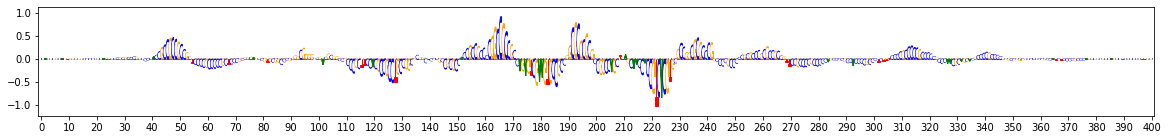

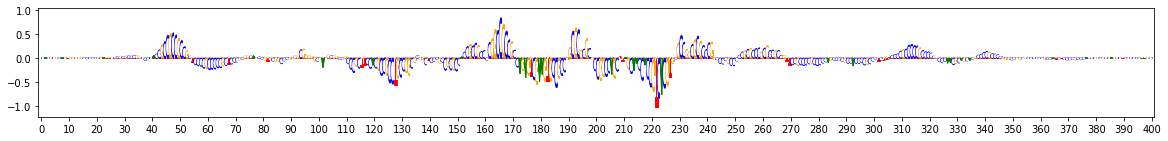

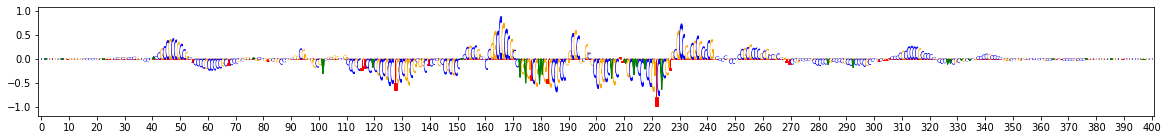

chr9:137551664-137552064



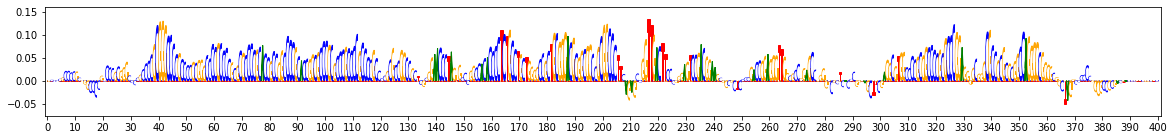

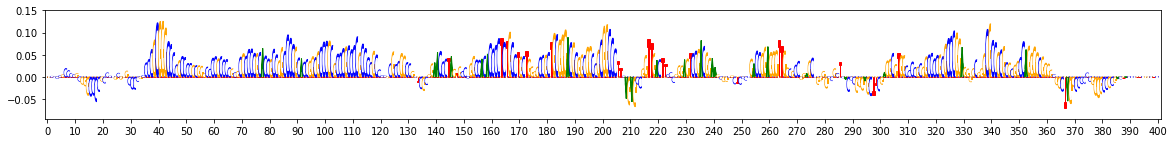

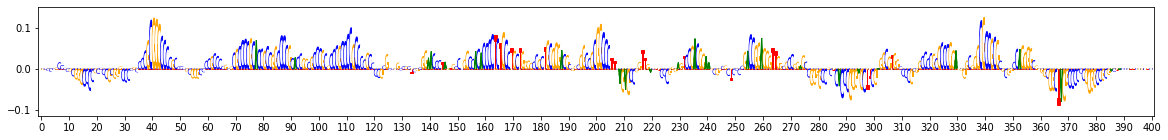

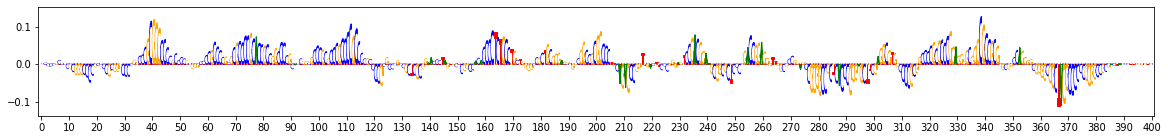

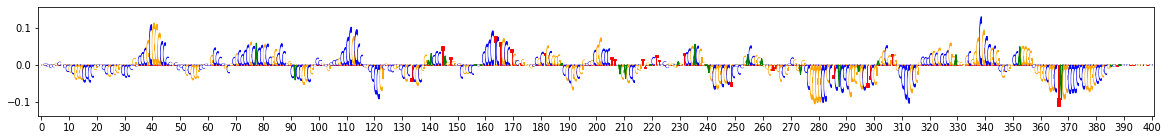

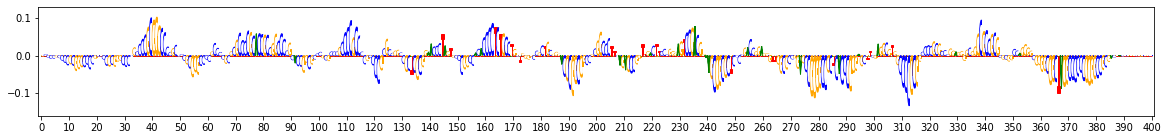

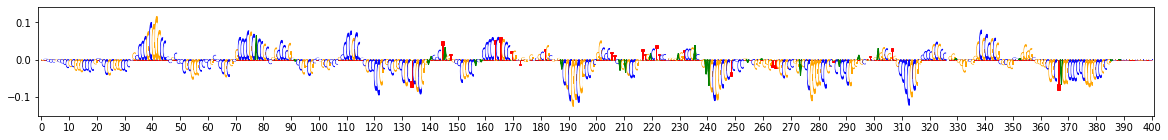

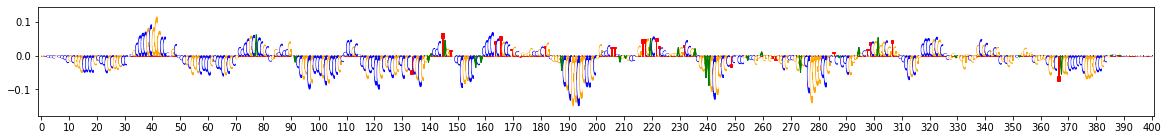

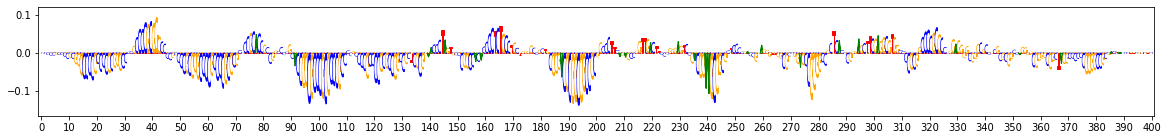

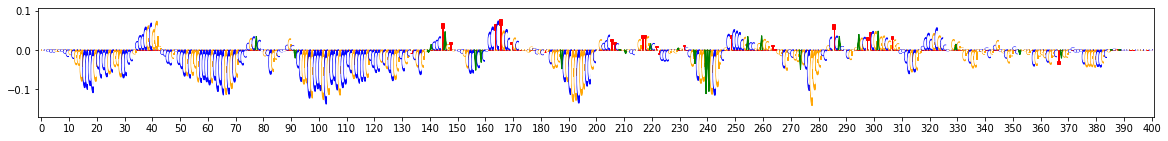

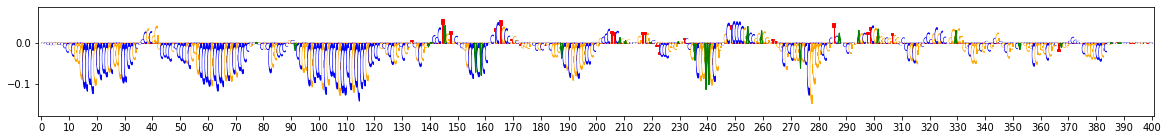

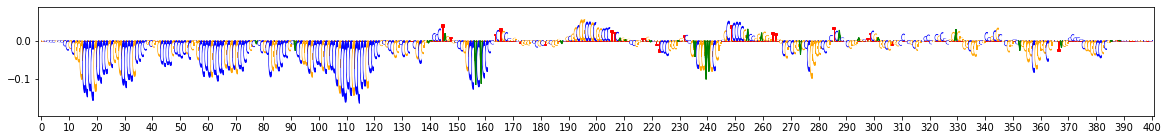

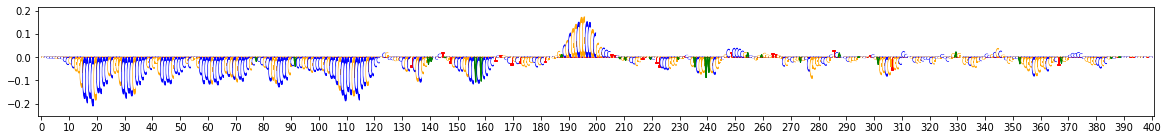

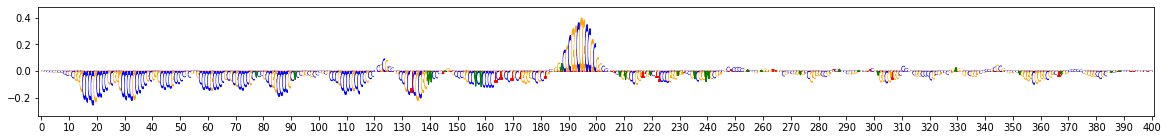

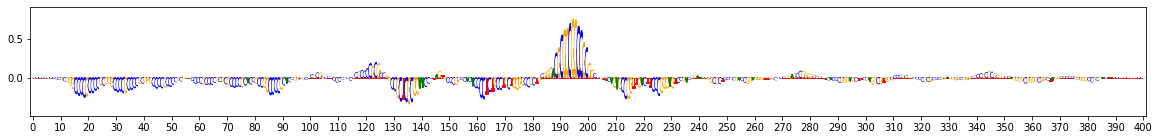

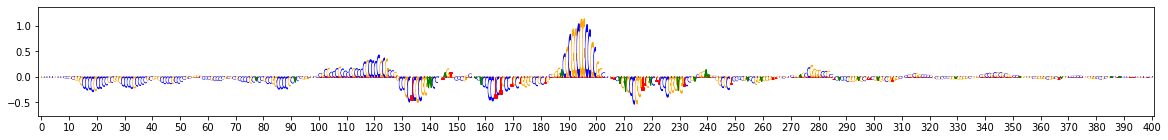

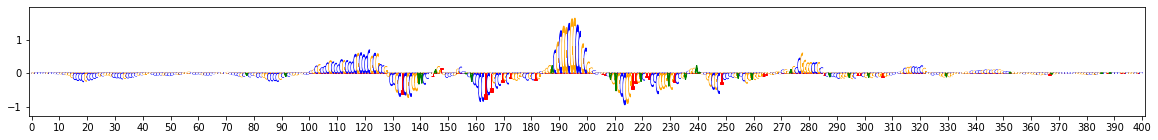

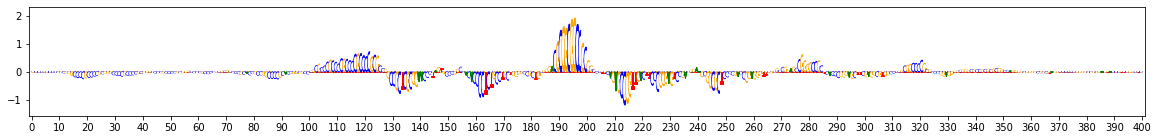

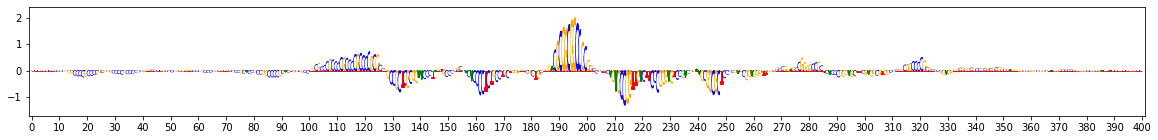

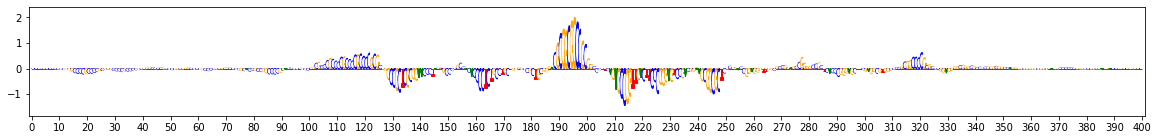

chr21:43426948-43427348



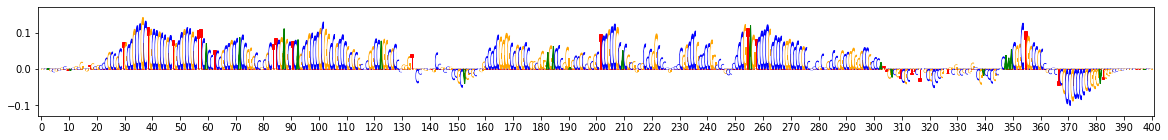

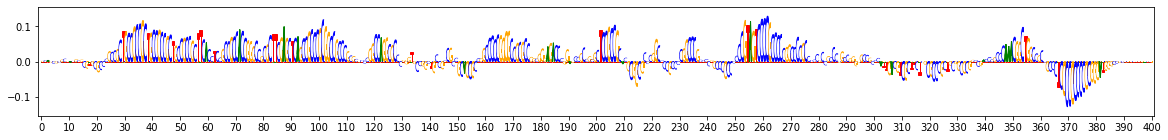

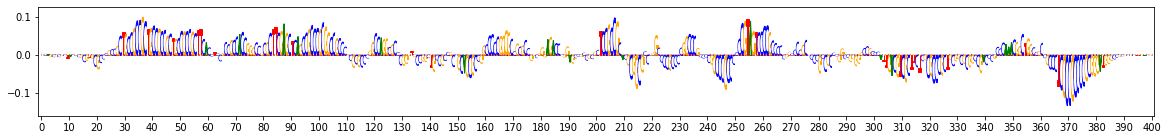

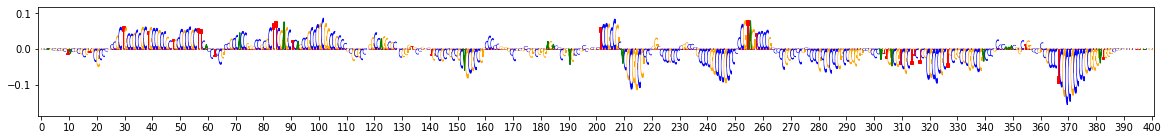

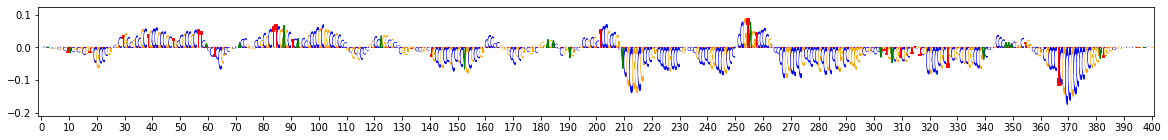

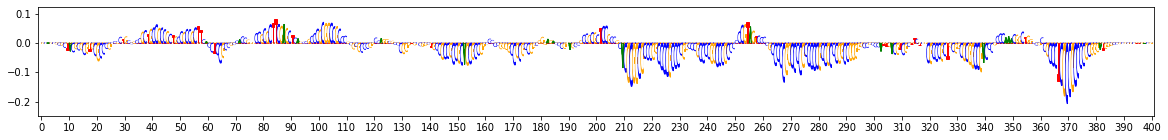

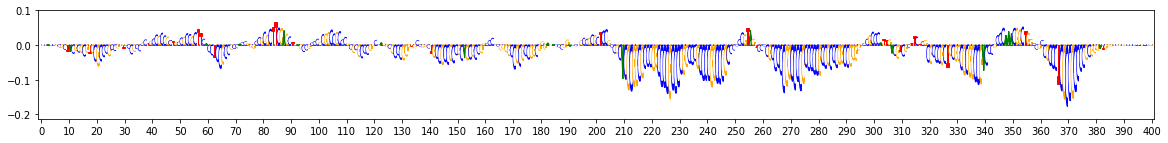

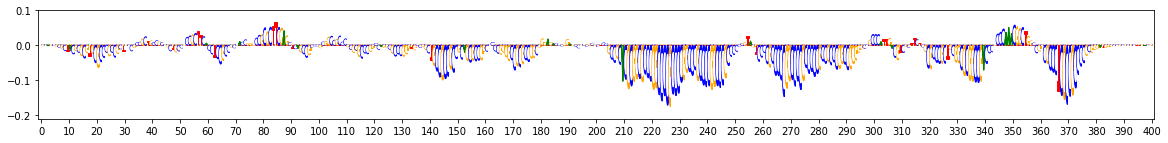

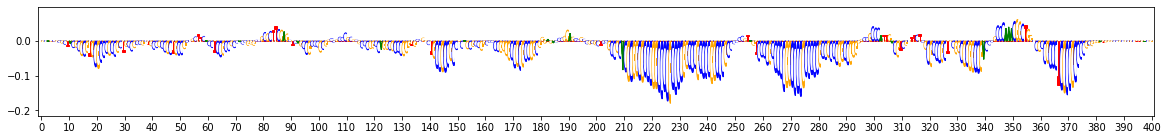

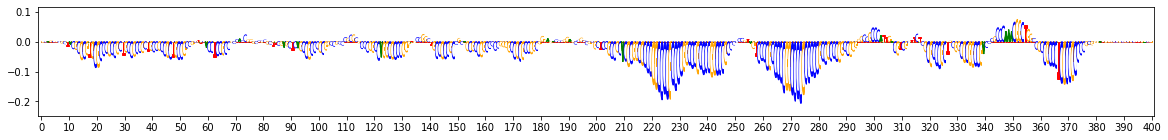

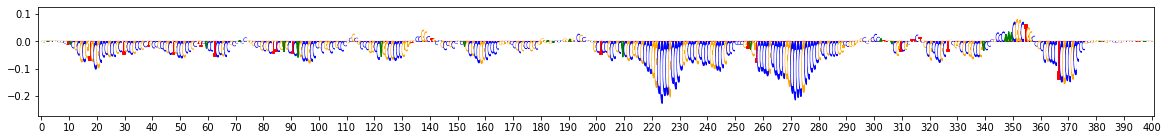

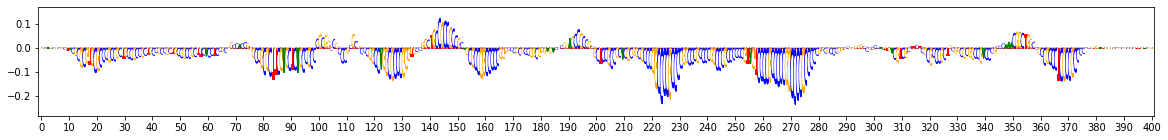

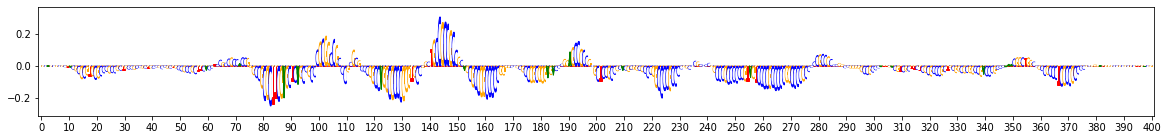

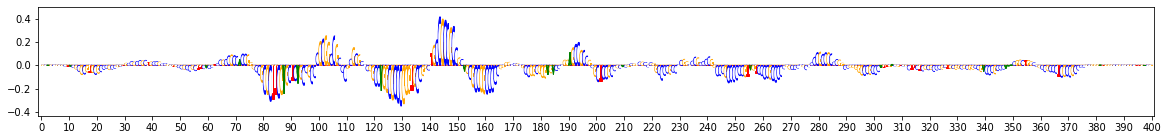

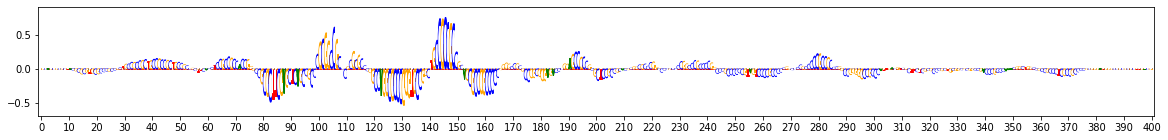

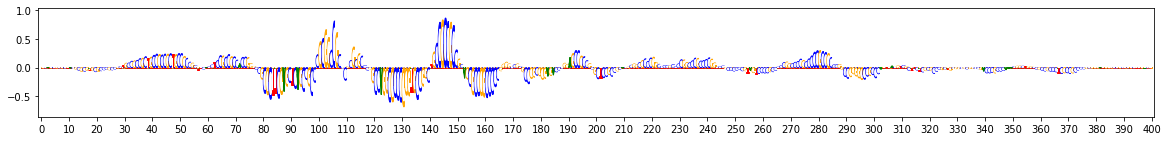

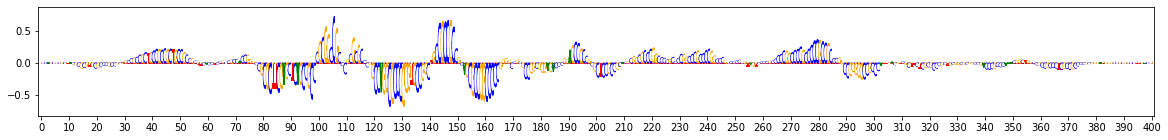

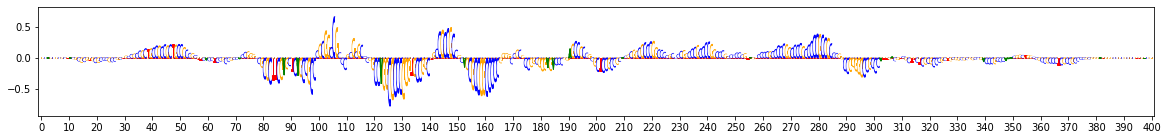

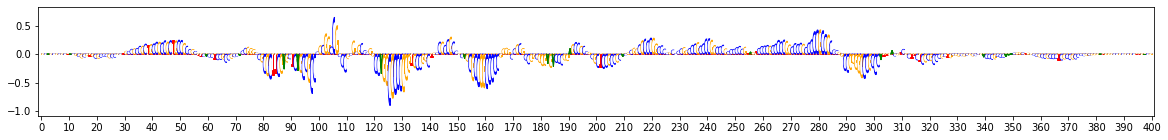

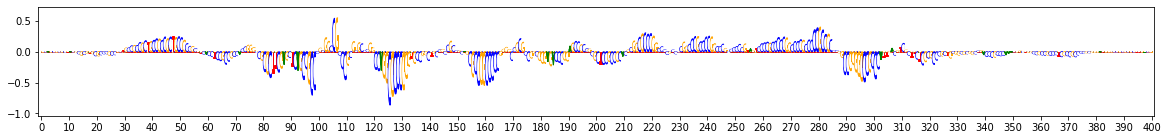

In [12]:
%matplotlib inline
from deeplift.visualization import viz_sequence
for seq in range(len(seqids)):
    print(str(seqids[seq]) + "\n")
    onehot_for_seq = onehot_data[seq]
    for interp in range(20):
        grads_for_interp = mean_ref_ig20_shuff20_grads[seq][interp]
        #print("Grads shape: " + str(grads_for_interp.shape))
        #print("Onehot shape: " + str(onehot_for_seq.shape))
        scores = onehot_for_seq*grads_for_interp[:,None]
        viz_sequence.plot_weights(scores, subticks_frequency=10)
        #highlight={'blue':[(motif['begin'],motif['end']) for motif in motif_matches[ex]]}